# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
# we also need to import:
from operator import add, itemgetter
import math
import pickle

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


We import into pyspark the ratings data.

In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## 3.5. Basic Statistics

Now, we are going to extract the basic statistics of data. For that we **only** use *Spark RDD* transformations.   

In [4]:
type(data)

pyspark.rdd.PipelinedRDD

Here we see that our data corresponds with the one we observed previously.

In [5]:
data.take(10)

[{'movieId': 2, 'userId': 1, 'timestamp': 1112486027, 'rating': 3.5},
 {'movieId': 29, 'userId': 1, 'timestamp': 1112484676, 'rating': 3.5},
 {'movieId': 32, 'userId': 1, 'timestamp': 1112484819, 'rating': 3.5},
 {'movieId': 47, 'userId': 1, 'timestamp': 1112484727, 'rating': 3.5},
 {'movieId': 50, 'userId': 1, 'timestamp': 1112484580, 'rating': 3.5},
 {'movieId': 112, 'userId': 1, 'timestamp': 1094785740, 'rating': 3.5},
 {'movieId': 151, 'userId': 1, 'timestamp': 1094785734, 'rating': 4.0},
 {'movieId': 223, 'userId': 1, 'timestamp': 1112485573, 'rating': 4.0},
 {'movieId': 253, 'userId': 1, 'timestamp': 1112484940, 'rating': 4.0},
 {'movieId': 260, 'userId': 1, 'timestamp': 1112484826, 'rating': 4.0}]

In [6]:
data_count = data.count()
print(f'There are a total of {data_count} ratings of movies in the dataset')

There are a total of 20000263 ratings of movies in the dataset


We define this lambda functions that we will use later.

We could also use the `itergetter()` function to get the `userId` and `movieId`, but for this, we have preferred to use our own declared functions.

Later, we will apply this functions to our ratings RDD in order to get only the `userId` and `movieId` respectively. That's the reason why we discard `_` the value in the new RDD that will be created after the transformation.

In [16]:
get_user = lambda x: (x['userId'], _)
get_item = lambda x: (x['movieId'], _)

#### Number of ratings per user

In [5]:
ratings_user = data.map(get_user).countByKey()

This is the dictionary of the count of ratings of each user.

The keys are the User IDs and the values are the number of ratings of the corresponding user. 

In [6]:
ratings_user

defaultdict(int,
            {1: 175,
             2: 61,
             3: 187,
             4: 28,
             5: 66,
             6: 24,
             7: 276,
             8: 70,
             9: 35,
             10: 38,
             11: 504,
             12: 36,
             13: 62,
             14: 243,
             15: 49,
             16: 60,
             17: 26,
             18: 121,
             19: 50,
             20: 28,
             21: 163,
             22: 133,
             23: 102,
             24: 506,
             25: 121,
             26: 61,
             27: 69,
             28: 32,
             29: 177,
             30: 31,
             31: 246,
             32: 73,
             33: 50,
             34: 93,
             35: 195,
             36: 20,
             37: 20,
             38: 74,
             39: 20,
             40: 73,
             41: 59,
             42: 51,
             43: 87,
             44: 33,
             45: 44,
             46: 122,
           

In [7]:
min(ratings_user.values())

20

Every user has rated at least 20 movies.

In [8]:
print("There are a total of %d users that have rated at least 20 movies." % len(ratings_user))

There are a total of 138493 users that have rated at least 20 movies.


Now, in order to get more basic knowledge about our data, we plot the distribution of number of ratings per user.

In [9]:
ratings_user_values = np.array(list(ratings_user.values()))

In order to make a more good-looking plot, we will plot only the distribution for the users that have rated less than 2000 movies, which represent almost all the users.

In [10]:
dist_ratings_user = ratings_user_values[ratings_user_values <= 1000]

# how many users have rated more than 1000 movies???
users_more1000 = len(ratings_user_values)-len(dist_ratings_user)
print(f"Only {users_more1000} users have rated more than 2000 movies.")
print("That's only the %.2f%% of the users" % (users_more1000/len(ratings_user_values)*100))

Only 1884 users have rated more than 2000 movies.
That's only the 1.36% of the users


Text(0.5, 1.0, "Histogram of the user's ratings counting")

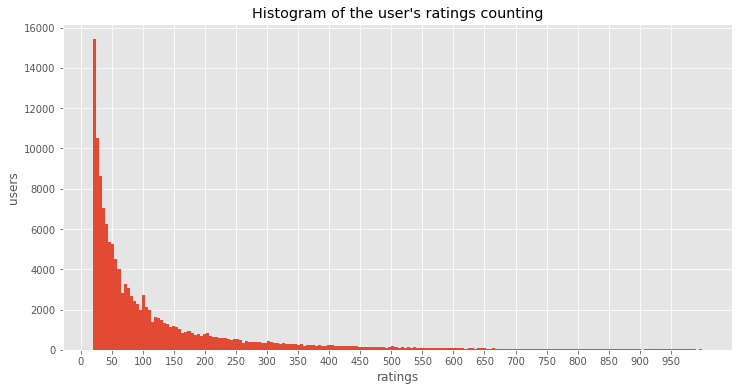

In [17]:
fig = plt.figure(figsize=(12,6))

plt.hist(dist_ratings_user,
        bins=200
        )
plt.xlabel('ratings')
plt.ylabel('users')
plt.xticks(np.arange(0,1000,50))
plt.title("Histogram of the user's ratings counting")

We can observe, that the number of ratings does not follows a uniform distribution, so there are a lot of users that have rated only 20-50 times and just a few that have rated a lot of times. Instead, this distribution fits with a Pareto distribution with $\alpha$=1.008.

In [12]:
mean = dist_ratings_user.mean()
mean

125.90090696806213

In [13]:
alpha = mean / (mean - 1)
alpha

1.0080063469855804

In [14]:
len(ratings_user_values)

138493

In [15]:
np.sum(ratings_user_values <= 200) / len(ratings_user_values) * 100

80.79397514675833

We have discarded from the plot all users with more than 1000 ratings (only 1.36% of the users) in order to plot better the distribution of the number of ratings per user.

As we can see in the plot, the most of the users have rated between 20 and and 200 movies (80.8% of users).

#### Number of ratings per item

Now we repeat we do the same for the number of ratings per item distribution.

In [18]:
ratings_item = data.map(get_item).countByKey()

In [19]:
# cuantos items hay ? item = movie
n_movies = len(ratings_item)
print("There are %d rated movies in our data." % n_movies)

There are 26744 rated movies in our data.


In [20]:
ratings_item

defaultdict(int,
            {2: 22243,
             29: 8520,
             32: 44980,
             47: 43249,
             50: 47006,
             112: 11890,
             151: 12616,
             223: 23695,
             253: 27568,
             260: 54502,
             293: 25804,
             296: 67310,
             318: 63366,
             337: 17881,
             367: 34384,
             541: 30526,
             589: 52244,
             593: 63299,
             653: 14192,
             919: 23445,
             924: 25253,
             1009: 2604,
             1036: 30399,
             1079: 19674,
             1080: 20557,
             1089: 27635,
             1090: 15808,
             1097: 32685,
             1136: 33024,
             1193: 29932,
             1196: 45313,
             1198: 43295,
             1200: 27206,
             1201: 14496,
             1208: 23090,
             1214: 30933,
             1215: 12469,
             1217: 4824,
             1219: 19649,

In [21]:
# we take only the values of the dictionary in order to get the plot distribution
rated_items_values = np.array(list(ratings_item.values()))

Here we can see that the half (50%) of the movies have been rated 18 or less times. 

In [23]:
np.median(sorted(rated_items_values))

18.0

In [22]:
dist_rated_items = rated_items_values[rated_items_values <= 3000]

# how many movies have been rated more than 3000 times???
items_more3000 = n_movies-len(dist_rated_items)
print(f"Only {items_more3000} movies have been rated more than 3000 times.")
print("That's only the %.2f%% of the movies" % (items_more3000/n_movies*100))

Only 1544 movies have been rated more than 3000 times.
That's only the 5.77% of the movies


As we have done before in order to get a good-looking plot distribution of the users ratings, now we plot only the distribution of the movies with less than 3000 ratings, because they are the 95% of our data. 

Text(0.5, 1.0, "Histogram of the movies' ratings counting (only movies rated less than 3000 times)")

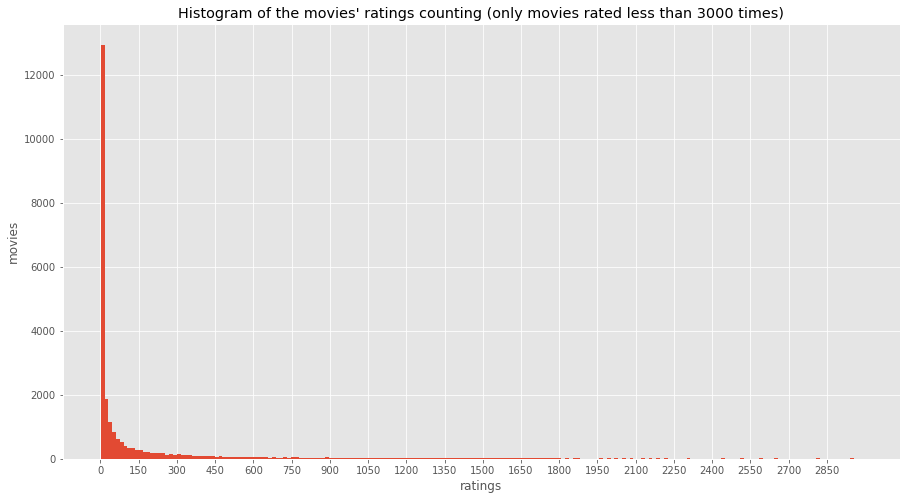

In [26]:
fig = plt.figure(figsize=(15,8))
plt.hist(dist_rated_items,
        bins=200
        )
plt.xticks(np.arange(0,3000,150))
plt.ylabel('movies')
plt.xlabel('ratings')
plt.title("Histogram of the movies' ratings counting (only movies rated less than 3000 times)")

As we can see here, the very most of the movies have been rated between 1 and 150 times.

In [59]:
print(f"The %.1f %% of the movies have been rated less than 150 times." %( np.sum(rated_items_values <= 150)/n_movies*100))

The 72.1 % of the movies have been rated less than 150 times.


So, now we also plot only the movies rated less than 150 times, in order to see better the distribution in this interval.

Text(0.5, 1.0, "Histogram of the movies' ratings counting (only movies rated less than 100 times)")

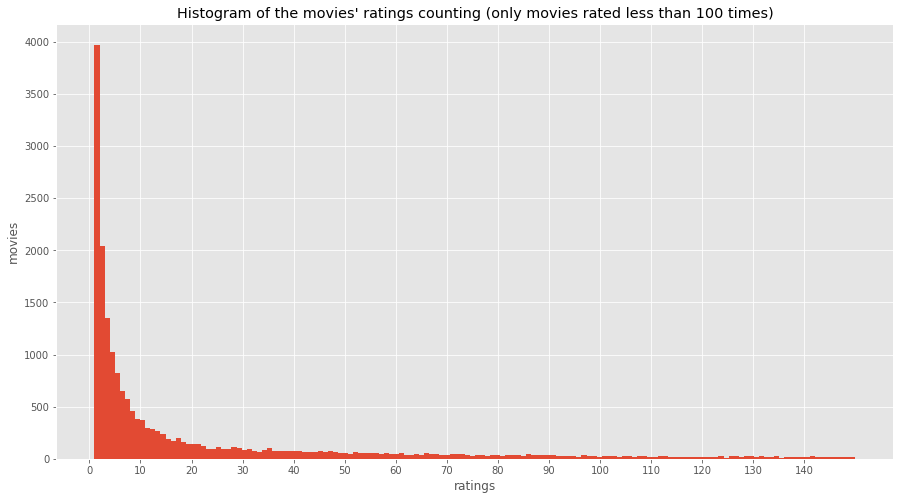

In [25]:
threshold = 150

fig = plt.figure(figsize=(15,8))
plt.hist(rated_items_values[rated_items_values <= threshold],
        bins=threshold
        )
plt.xticks(np.arange(0,threshold,10))
plt.ylabel('movies')
plt.xlabel('ratings')
plt.title("Histogram of the movies' ratings counting (only movies rated less than 100 times)")

Here the percentiles give us another perspective of the distribution. As we can see, the most of the movies have been rated a few times, and only the 25% have been rated more than 200 times.

And the 25% have been rated 3 or less times.

In [61]:
print(np.percentile(rated_items_values,[0,25,50,75,100]).astype(int))

[    1     3    18   205 67310]


In [65]:
max(rated_items_values)

67310

As the more rated movies are the most populars, we think that it is important to get the plot distribution of the most popular movies.
In this case we select the movies with more than 10.000 ratings.

Text(0.5, 1.0, "Histogram of the user's ratings counting (only movies rated more than 10000 times)")

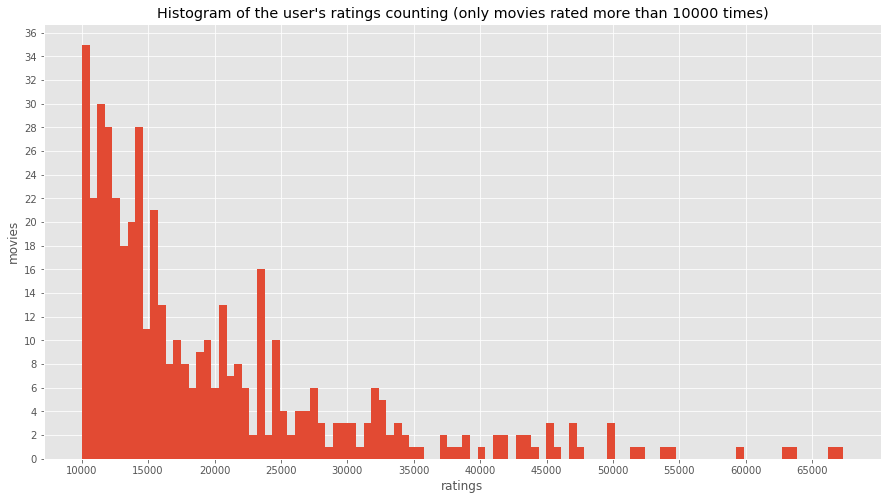

In [31]:
threshold = 10000

fig = plt.figure(figsize=(15,8))
plt.hist(rated_items_values[rated_items_values >= threshold],
        bins=100
        )
plt.xticks(np.arange(threshold,max(rated_items_values),5000))
plt.yticks(np.arange(0,38,2))
plt.ylabel('movies')
plt.xlabel('ratings')
plt.title("Histogram of the user's ratings counting (only movies rated more than 10000 times)")

Does not matter which data interval (e.g. less or most rated movies) we take that data follows the same distribution.

## Creating our own ratings

We have ran the `rate-movies.py` file and rated a total of 11 movies. Now we append this ratings to the ratings.txt file.

We have decided to do that by putting our txt file in HDFS.

In [4]:
!hdfs dfs -put my-ratings.txt

put: `my-ratings.txt': File exists


In [5]:
!hdfs dfs -ls

Found 4 items
drwx------   - prunonos hadoop          0 2022-04-29 19:00 .Trash
drwxr-xr-x   - prunonos hadoop          0 2022-05-05 08:33 .sparkStaging
-rw-r--r--   3 prunonos hadoop    2147813 2022-02-23 12:07 election-day-tweets.txt
-rw-r--r--   3 prunonos hadoop        803 2022-04-28 18:55 my-ratings.txt


We can observe now, that both ratings files have the same data format and structure

In [6]:
!hdfs dfs -cat my-ratings.txt

{"movieId": 1, "userId": 138494, "timestamp": 1651084465, "rating": 4}
{"movieId": 780, "userId": 138494, "timestamp": 1651084468, "rating": 5}
{"movieId": 590, "userId": 138494, "timestamp": 1651084470, "rating": 2}
{"movieId": 1210, "userId": 138494, "timestamp": 1651084472, "rating": 1}
{"movieId": 648, "userId": 138494, "timestamp": 1651084475, "rating": 2}
{"movieId": 344, "userId": 138494, "timestamp": 1651084476, "rating": 1}
{"movieId": 165, "userId": 138494, "timestamp": 1651084480, "rating": 2}
{"movieId": 153, "userId": 138494, "timestamp": 1651084481, "rating": 1}
{"movieId": 597, "userId": 138494, "timestamp": 1651084483, "rating": 3}
{"movieId": 1580, "userId": 138494, "timestamp": 1651084484, "rating": 3}
{"movieId": 231, "userId": 138494, "timestamp": 1651084486, "rating": 2}


In [7]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


We import our ratings into PySpark context.

In [4]:
my_ratings = sc.textFile("my-ratings.txt").map(json.loads)

In [5]:
my_ratings.take(2)

[{'movieId': 1, 'userId': 138494, 'timestamp': 1651084465, 'rating': 4},
 {'movieId': 780, 'userId': 138494, 'timestamp': 1651084468, 'rating': 5}]

We use `union` PySpark context function to merge both RDDs.

In [6]:
new_data = sc.union([data,my_ratings])

In [7]:
type(new_data)

pyspark.rdd.RDD

In [10]:
new_data.take(5)

[{'movieId': 2, 'userId': 1, 'timestamp': 1112486027, 'rating': 3.5},
 {'movieId': 29, 'userId': 1, 'timestamp': 1112484676, 'rating': 3.5},
 {'movieId': 32, 'userId': 1, 'timestamp': 1112484819, 'rating': 3.5},
 {'movieId': 47, 'userId': 1, 'timestamp': 1112484727, 'rating': 3.5},
 {'movieId': 50, 'userId': 1, 'timestamp': 1112484580, 'rating': 3.5}]

In [8]:
new_data_count = new_data.count()
print(f'There are a total of {new_data_count} ratings of movies in the dataset')
print(f'We can observe that now we have {new_data_count - data_count} new elements')

There are a total of 20000274 ratings of movies in the dataset
We can observe that now we have 11 new elements


## 3.6. Partitionating the dataset

Now we proceed to split the dataset into a *training* and a *validation* set before start to create any recommender model.


In order to particionate the dataset, we will filter the ratings on the last digit of the timestamp, because it will ensure as randomness while keeping reproducibility at the same time.

In [10]:
last_digit_timestamp = lambda x: (x['timestamp'] % 10, _) # function to take last digit of timestamp

We check that there are approximately the same number of ratings per timestamp digit.

In [11]:
last_digit_count = new_data.map(last_digit_timestamp).countByKey()
last_digit_count

defaultdict(int,
            {7: 1998951,
             6: 1998912,
             9: 2001320,
             0: 1999677,
             4: 2001333,
             3: 2000306,
             8: 2000005,
             1: 2000614,
             5: 1999920,
             2: 1999236})

In [12]:
last_digit_count = np.array(list(last_digit_count.values()))

In [13]:
np.sum(last_digit_count[-2:]) / np.sum(last_digit_count[:-2]) * 100

24.992978615619233

As it was expected, the timestamp's last digit is distributed uniformly, so we can use 2 digits as validation, that represents 25% of all the data.

We are using PySpark `filter` function to split the data based on the last timestamp digit. We have decided to use 0 and 1 as `test_data`.

In [8]:
train_data = new_data.filter(lambda x: x['timestamp'] % 10 not in [0,1])
test_data  = new_data.filter(lambda x: x['timestamp'] % 10 in [0,1])

In [43]:
train_data.count()

15999983

In [44]:
test_data.count()

4000291

This is ~75% of the data for the training set, and ~25% for the test.

# BASELINE RECOMMENDER SYSTEM

## 3.7. Baseline Model

With the aim of finding our recommender model, we will implement a first recommender model that will be a baseline model.

This basic model will be used as benchmark for our future models, in which we will try to improve the results of the Baseline. 

We predict the rating of user $u$ for movie $m$ as:

$\hat{r}_{um} = \mu + \alpha_u + \beta_m$

First, we will compute the global average rating ($\mu$) of the training data.

In [9]:
global_average_rating = train_data.map(lambda x: x['rating']).mean()

In [10]:
global_average_rating

3.5255069646011554

We broadcast the global average rating variable through all the nodes because it will be needed to compute the other parameters..

In [11]:
sc.broadcast(global_average_rating)

In order to predict later the ratings of the test set, we need to assign a `user_bias` ($\alpha$) and a `remaining_item_bias` ($\beta$) with value of 0 to all the data, due to there are some data that only appears in the test set and not in the training set but we still need the values of these two parameters.

So we will create two RDDs, one with all values to 0 (for all the data) and other with the real values for the training data.

In [12]:
movies = new_data.map(itemgetter('movieId')).distinct().collect()
users  = new_data.map(itemgetter('userId')).distinct().collect()

In [13]:
user_bias_0 = sc.parallelize([(user,0) for user in users])
movies_bias_0 = sc.parallelize([(movie,0) for movie in movies])

Now we create the RDD with the `user_bias` for the training data.

In [14]:
ratings_user = train_data.map(get_user).countByKey()

NameError: name 'get_user' is not defined

In [ ]:
user_bias_real = (train_data.map(lambda x: (x['userId'], x['rating'] - global_average_rating))
                      .reduceByKey(add)
                      .map(lambda x: (x[0], x[1] / ratings_user[x[0]] ))
#                       .collect()
                      )

Here is an example of 5 real user bias from the training data. The key corresponds to the user ID $u$ and the value is his user bias $\alpha_u$.

In [21]:
user_bias_real.take(5)

[(124460, -0.4536542330097098),
 (124474, 0.09449303539884457),
 (124488, 0.004796065701874879),
 (124502, 0.5558883842360534),
 (124516, 0.09949303539884458)]

In [22]:
user_bias_0.take(5)

[(49896, 0), (49910, 0), (49924, 0), (49938, 0), (49952, 0)]

Here, we join both RDDs with `union`. So now we will have the real user bias value for the training data, and also a value of 0 in the user bias of the validation data.

In [ ]:
user_bias = user_bias_real.union(user_bias_0).reduceByKey(add).collectAsMap()
# we reduce with add, because 0 + x = x

In [ ]:
# we check that we have all the users in user_bias

assert len(user_bias) == len(users)

Now, we are going to compute the remaining item bias. In order to do that, first we must calculate the number of ratings per item in the training data.

We will repeat the same process as with `user_bias`.

In [ ]:
ratings_item = train_data.map(get_item).countByKey()

In [ ]:
subs_lambda = lambda x: (x['movieId'], x['rating'] - global_average_rating - user_bias[x['userId']]) 

remaining_item_bias_real = (train_data.map(subs_lambda)
                      .reduceByKey(add)
                      .map(lambda x: (x[0], x[1] / ratings_item[x[0]] ))
                      )

remaining_item_bias_real

In [ ]:
remaining_item_bias = remaining_item_bias_real.union(movies_bias_0).reduceByKey(add).collectAsMap()
remaining_item_bias

In [ ]:
assert len(remaining_item_bias) == len(movies)

We have `user_bias` that has a length of N users, and we have `remaining_item_bias` that has a length of M movies. So we will have N + M parameters. Let's see what is the exact amount of each.

In [29]:
print(f'We have a total of {len(ratings_user)} users and {len(ratings_item)} movies in the training set.')
print(f'So, we have a total amount of {len(ratings_user) + len(ratings_item)} parameters.')

We have a total of 138458 users and 25868 movies in the training set.
So, we have a total amount of 164326 parameters.


However, we think that the creation of the 0-value user bias $\alpha$ or item bias $\beta$ is not the optimal solution. It would be better for example to ask the user for the type of content he/she likes or predict the rating based on the item content. But, in any case this is only a baseline.

#### Prediction of ratings of the validation set

Once we have computed the parameters we can predict the validation ratings.

In [ ]:
predict = (lambda x : ( (x['userId'], x['movieId']),
                      global_average_rating + user_bias[x['userId']] + remaining_item_bias[x['movieId']]))

In [34]:
predictions = test_data.map(predict)
predictions.take(5)

[((1, 50), 4.467954194198161),
 ((1, 112), 3.6885060426375795),
 ((1, 253), 3.7216453682283657),
 ((1, 367), 3.3938553801249576),
 ((1, 593), 4.302769002501195)]

## 3.8. Evaluation

Our next step is to implement an error function that computes the prediction errors with respect to the validation set.

The error function will be this one:

$error = \frac{1}{U}\sum_{u}\sqrt{\frac{1}{N_u}\sum_{m}(\hat{r}_{um}-r_{um})^2}$

where $U$ is the number of users.

In [17]:
ratings_user = test_data.map(get_user).countByKey() # we need to know the number of ratings of a user

In [18]:
# we change the shape of our test set to be the same of the predictions.
test_data_format = test_data.map(lambda x: ( (x['userId'], x['movieId']), x['rating']) )

We union the predictions and the labels of the test data, and we compute the error of each prediction.

In [19]:
error_rating = predictions.union(test_data_format).reduceByKey(lambda x,y: (x-y)**2)

NameError: name 'predictions' is not defined

In [42]:
error_rating.take(3)

[((24728, 370), 0.00011183649918110553),
 ((24728, 586), 0.0068526349088094355),
 ((24731, 3275), 0.2059659588634896)]

Then, we compute the error of each user.

In [ ]:
error_user = (error_rating.map(lambda x: (x[0][0], x[1]))
                         .reduceByKey(add) 
                         .map(lambda x: (x[0], math.sqrt(x[1]/ratings_user[x[0]])) )
                         )

And finally we compute the mean error of all the users.

In [44]:
error_user.values().sum() / error_user.count()

0.8683735575531708

Now we create a function that computes the error (same as right above) in order to use it later in our more complex models.

In [ ]:
sc.broadcast(ratings_user) # we broadcast the ratings_user dictionary to every node.

In [ ]:
def error_func(test_data,pred):
    # input format: ( userId, movieId , rating )
    # we have to key the data to this format, where userId and movieId are the keys: ( ( userId , movieId ) , rating )
    test_data = test_data.map(lambda x: ( (x['userId'],x['movieId']) , x['rating']) )
    
    error_rating = pred.union(test_data).reduceByKey(lambda x,y: (x-y)**2)
    error_user = (error_rating.map(lambda x: (x[0][0], x[1]))
                         .reduceByKey(add) 
                         .map(lambda x: (x[0], math.sqrt(x[1]/ratings_user[x[0]])) )
                         )
    aux = error_user.collect()
    return error_user.values().sum() / error_user.count()

# MATRIX-FACTORIZATION MODEL

Now, we consider a more powerful class of model, that improves the baseline performance, based on factorizing the rating matrix.

Matrix factorization is a way to generate latent features to identify relationship between items and users and also as a way to solve the sparse data problem of the rating matrix. It will help us to improve our prediction perfomance.

We implement a model based on ALS (Alternating Least Squares). ALS is also a matrix-factorization algorithm that minimize the error function in one of the latent features matrix (Q) and fixes the other (P), in order to minimize it in a quadratic form. Then, it fixes the previously minimized matrix (Q) and minimize the previously fixed one (P). It repeats the process until convergence.

In [20]:
from pyspark.mllib.recommendation import ALS

## 3.9. Regularization

Now we train our model with ALS, but we have to get the optimal value of $\lambda$ in order to avoid overfitting.

The first think we do is create a training function to which we pass the training data (`ratings`), test data, the number of features of the Matrix-Factorization model and the value of $\lambda$, that will prevent from overfitting.

The function will return us the square mean error value of the ALS model predictions. 

In [21]:
def train_model_ALS(ratings, test_data, rank, lambda_, iterations=5, seed=1):
    ratings = ratings.map(itemgetter('userId','movieId','rating'))
    test_data_ALS = test_data.map(itemgetter('userId','movieId'))
    
    model = ALS.train(ratings, rank, iterations=5, lambda_=lambda_, seed=seed)
    predictions = (model.predictAll(test_data_ALS)
                        .map(lambda x: ((x.user, x.product), x.rating)))
    return error_func(test_data, predictions)

This is the result with 5 latent features and $\lambda=0.0001$.

In [51]:
train_model_ALS(train_data, test_data, rank=5, lambda_=1.0e-4, seed=1)

0.8713814669517643

With $\lambda$=0.0001 we have that our model accuracy has not increased significantly. That it's because our $\lambda$ is very small and it does not regularize enough, so our model is probably overfitting.

Let's try now with different values of $\lambda$ and with different `rank` values in order to get their optimal values.

In [57]:
lambda_values = [1.0e-5, 1.0e-3, 1.0e-1, 1.0, 5.0, 10.0]
rank_values = [5,10,15,20]

In [22]:
def error_fun(rank_values, lambda_values): 
    error = {}

    for rank in rank_values:
        error_rank = [] 
        for lambda_ in lambda_values:
            err = train_model_ALS(train_data,test_data,rank=rank,lambda_=lambda_)
            error_rank.append(err)
        error[rank] = error_rank
    
    return error 

In [59]:
error = error_fun(rank_values,lambda_values)

Here we plot the error values with different rank and $\lambda$ values.

In [87]:
# np.save('error_lambdarank.npy',error)
error

{5: [0.9117625327487445,
  0.835469890454195,
  0.8162947331699929,
  1.3345416619114006,
  3.7463156909868514,
  3.746315706910596],
 10: [0.9646109771924795,
  0.8543376154676887,
  0.8089129143337099,
  1.333171304820086,
  3.7463156589663447,
  3.7463157069105817],
 15: [1.151582687637061,
  0.8958950921967976,
  0.8201870067595696,
  1.330435276831972,
  3.74631567163501,
  3.746315706910595],
 20: [1.3358077316797707,
  0.9304231587460913,
  0.8170593524058991,
  1.3292716902171078,
  3.746315663907881,
  3.746315706910593]}

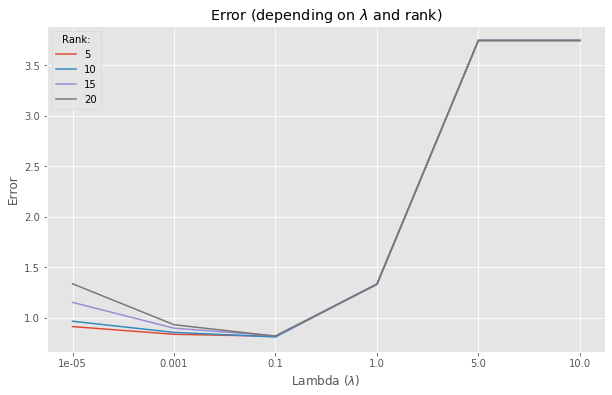

In [86]:
plt.figure(figsize=(10,6))
plt.title('Error (depending on $\lambda$ and rank)')
plt.xlabel('Lambda ($\lambda$)')
plt.ylabel('Error')
for k in error:
    plt.plot([str(e) for e in lambda_values],error[k])
plt.legend(rank_values,title='Rank:')

So, the best hyperparameters for our model are: $\lambda$=0.1 and rank=10

In [88]:
train_model_ALS(train_data, test_data, rank=10, lambda_=0.1, seed=1)

0.8088398117221223

Now, in order to use it later we save our best model.

In [23]:
ratings = train_data.map(itemgetter('userId','movieId','rating'))
model = ALS.train(ratings, rank=10, iterations=5, lambda_=0.1, seed=1)

## 3.10. Recommendation

We import the `movies.txt` file and we create the dictionary.

In [24]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2

{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [25]:
movies_txt = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

In [26]:
movies_dict = movies_txt.map(itemgetter('movieId','title')).collectAsMap()
movies_dict

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

We use our model to recommend the best 10 movies for the user 123.

In [27]:
model.recommendProducts(123,10)

[Rating(user=123, product=101862, rating=4.786715558994331),
 Rating(user=123, product=98595, rating=4.412297191894371),
 Rating(user=123, product=99493, rating=4.318450399462379),
 Rating(user=123, product=109199, rating=4.295293160357652),
 Rating(user=123, product=120134, rating=4.286530865159909),
 Rating(user=123, product=113474, rating=4.271141403366395),
 Rating(user=123, product=95937, rating=4.2536238085677045),
 Rating(user=123, product=112423, rating=4.236471058144705),
 Rating(user=123, product=72235, rating=4.220146919712022),
 Rating(user=123, product=107477, rating=4.219606524881224)]

We can see the title of these movies using the dictionary we created previously.

In [169]:
[movies_dict[movie.product][:-6] for movie in model.recommendProducts(123,10)]

['50 Children: The Rescue Mission of Mr. And Mrs. Kraus ',
 'Peppermint Soda (Diabolo menthe) ',
 'Moth, The (Cma) ',
 'God’s Wedding (As Bodas de Deus) ',
 'Big Night, The ',
 'Otakus in Love ',
 'Hellhounds on My Trail ',
 'Plastic Bag ',
 'Return to the 36th Chamber (Shao Lin da peng da shi) (',
 'Konopielka ']

Now, we show the recommended movies our model suggests us.

In [163]:
model.recommendProducts(138494,10) 

[Rating(user=138494, product=82602, rating=4.543610635357732),
 Rating(user=138494, product=111878, rating=4.4260385040608465),
 Rating(user=138494, product=128600, rating=4.267183506393066),
 Rating(user=138494, product=83435, rating=4.209711732299024),
 Rating(user=138494, product=120821, rating=4.073186516909982),
 Rating(user=138494, product=107743, rating=4.002441150807066),
 Rating(user=138494, product=100058, rating=3.8814182596263342),
 Rating(user=138494, product=86237, rating=3.7548519254056654),
 Rating(user=138494, product=86947, rating=3.745785476754065),
 Rating(user=138494, product=26459, rating=3.7247613206431476)]

In [168]:
[movies_dict[movie.product][:-6] for movie in model.recommendProducts(138494,10)]

['Titanic Town ',
 '#chicagoGirl: The Social Network Takes on a Dictator ',
 'John Doe: Vigilante ',
 'Hatful of Rain, A ',
 'The War at Home ',
 'Class of 92, The ',
 "Patrice O'Neal: Elephant in the Room ",
 'Connections ',
 "Van Diemen's Land ",
 'Scarlet Pimpernel, The ']

## 3.11. Visualization

In this case we focus on a ALS model of rank 2, what it means there are 2 latent features.

Then, we will create an interactive plot embeding some selected movies along the 2 latent features.

First of all, we see which is the best $\lambda$ value for rank of 2.

In [99]:
error_rank2 = error_fun([2],[0.001,0.01,0.1,1.0])

In [100]:
error_rank2

{2: [0.8543277060252693,
  0.8511444872777983,
  0.8312236490973663,
  1.3429011928884669]}

Now we train our model with the best $\lambda$. In this case, $\lambda=0.1$ gives us the best results.

In [28]:
ratings = new_data.map(itemgetter('userId','movieId','rating'))
model = ALS.train(ratings, rank=2, iterations=5, lambda_=0.1, seed=1)

We import the selected movies that we want to plot.

In [29]:
with open("selected-movies.pickle", "rb") as f:
    movies_sel = pickle.load(f, encoding="utf-8")

In [30]:
movies_selId = np.array(movies_sel)[:,0].astype(int)
print(movies_selId)
# we import the selected movies into PySpark
movies_selId_dist = sc.parallelize(movies_selId)

[   780   5349   2571    318   2329   5147  55444  32296  43930   4658
   6774   3967 114028    480    260   4700    527   2959   6132   2858
   6016  94018   5687   1240 111759    356  81845   2324   5163   7235
   1199  48043   4465    805  74545  54503   2706]


The function `productFeatures` return us the optimized latent features for the products (movies).  

In [31]:
prod_feat = model.productFeatures()

We use `leftOuterJoin` to take only the product features of the selected movies. 

In [32]:
prod_feat_sel_dist = (movies_selId_dist.map(lambda x: (x,None))
                                 .leftOuterJoin(prod_feat) # after this : (selected_movieID, (None, features))
                                 .map(lambda x: (x[0],x[1][1]))) # but we only want : (selected_movieID, features)

Here we show 5 movies and their latent features.

In [33]:
prod_feat_sel = prod_feat_sel_dist.collect()
prod_feat_sel[:5]

[(260, array('d', [2.6336910724639893, -0.7641341090202332])),
 (780, array('d', [2.3649165630340576, 0.07632028311491013])),
 (2706, array('d', [2.1305320262908936, -0.5297572612762451])),
 (94018, array('d', [1.735540747642517, -0.528941810131073])),
 (1199, array('d', [2.2934255599975586, -1.3181134462356567]))]

Now, in order to visualize the movies along the 2 directions defined by the factorization, we need to import interactive plots library `bokeh`.

In [36]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [55]:
from matplotlib.colors import rgb2hex 
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": [x[1][0] for x in prod_feat_sel],
        "y": [x[1][1] for x in prod_feat_sel],
        "name": [movies_dict[x[0]] for x in prod_feat_sel],
        "color": [val2rgb(x[1][1]) for x in prod_feat_sel],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Movie features")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
# p.circle("x", "y", source=source, size=20, alpha=0.5)
show(p, notebook_handle=True)

In the interactive plot we can see how movies are distribitud along this two latent features.

However, we can't say that this two latent features correspond to a real movie feature such as the movie genre, because there is no intuitive intuition of that just looking the plot.
It's obvious that there are some items very close, so that means that they have been rated in a similar way, but do not necessarily means that they are part of the same genre of movies.

Now, we show the movie genres of the selected movies in order to compare it with the plot distribution. It can be checked that there is no intuitive correlation between the two latent features and the genre movies.

In [413]:
movies_txt_wkeys = movies_txt.keyBy(lambda x: x['movieId'])

movies_genres = (movies_selId_dist.map(lambda x: (x,None))
                                 .leftOuterJoin(movies_txt_wkeys)
                                 .map(lambda x: (x[1][1]['title'], x[1][1]['genres']))
                                 .collect())

In [415]:
for mov in np.sort(movies_genres,axis=0):
    print(f'{mov[0]} \t {mov[1]}')

Accused, The (1988) 	 ['Action', 'Adventure', 'Crime', 'Drama', 'Thriller']
American Beauty (1999) 	 ['Action', 'Adventure', 'Sci-Fi']
American History X (1998) 	 ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
American Pie (1999) 	 ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
Battleship (2012) 	 ['Action', 'Adventure', 'Sci-Fi', 'Thriller']
Billy Elliot (2000) 	 ['Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Thriller']
Brazil (1985) 	 ['Action', 'Crime', 'Drama', 'Thriller']
City of God (Cidade de Deus) (2002) 	 ['Action', 'Sci-Fi', 'IMAX']
Control (2007) 	 ['Action', 'Sci-Fi', 'Thriller']
Edge of Tomorrow (2014) 	 ['Action', 'Sci-Fi', 'Thriller']
Fight Club (1999) 	 ['Action', 'Sci-Fi', 'Thriller', 'IMAX']
Forrest Gump (1994) 	 ['Adventure', 'Comedy', 'Crime']
Fountain, The (2006) 	 ['Children', 'Comedy', 'Romance']
Ghost Writer, The (2010) 	 ['Comedy']
Ichi the Killer (Koroshiya 1) (2001) 	 ['Comedy', 'Drama']
Independence Day (a.k.a. ID4) (1996) 	 ['Comedy', 'Drama']
Jurassic Par